# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 78 kB 4.5 MB/s 
     |████████████████████████████████| 462 kB 28.4 MB/s 
  Created wheel for adapt: filename=adapt-0.4.0-py3-none-any.whl size=101264 sha256=58977f1323ead7c1f80dc612c23cee2c5c09ef1aebce62beee63cd8ae162d6eb
  Stored in directory: /root/.cache/pip/wheels/47/47/61/e923985c37a7075ec75c4b16295782354b1c5dd291d47a7637
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
BATCH_SIZE = 8
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

1939

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_test1), "rb") as f:
    TCGA_test1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
with open(os.path.abspath(Target_dir_test2), "rb") as f:
    TCGA_test2 = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train1['train'] + TCGA_train2['train']
TCGA_train_labels = np.concatenate((TCGA_train1['train_label'],TCGA_train2['train_label']))
TCGA_test_data = TCGA_test1['test'] + TCGA_test2['test']
TCGA_test_labels = np.concatenate((TCGA_test1['test_label'],TCGA_test2['test_label']))

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (3200, 256, 256, 3)
The shape of TCGA_train_labels:  (3200,)
The shape of TCGA_test_data:  (3200, 256, 256, 3)
The shape of TCGA_test_labels:  (3200,)


In [ ]:
import gc
gc.collect()

1001

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


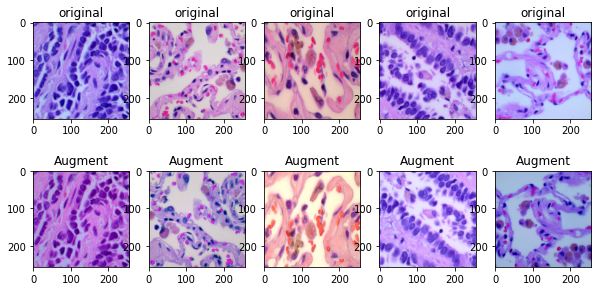

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

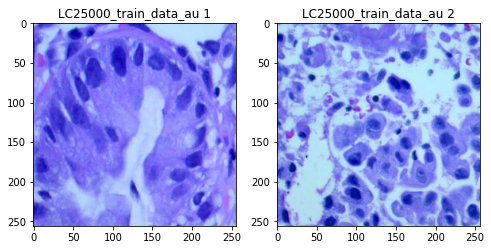

In [ ]:
# random show images
plt.subplots(1,2,figsize=(8,8))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.title("LC25000_train_data_au 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data_au 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

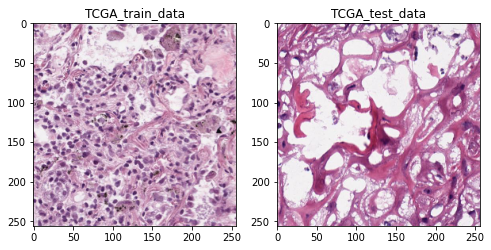

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(8,8))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_256.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))


print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data_au (source) shape: (3200, 256, 256, 3)
TCGA_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     )
optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    )

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.9090 - acc: 0.6553 - val_loss: 1.1063 - val_acc: 0.4409
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.5734 - acc: 0.7937 - val_loss: 1.0778 - val_acc: 0.4059
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.3737 - acc: 0.8625 - val_loss: 1.0697 - val_acc: 0.3800
Epoch 4/5
400/400 [==============================] - 3s 9ms/step - loss: 0.2724 - acc: 0.9034 - val_loss: 1.0926 - val_acc: 0.4137
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.2165 - acc: 0.9241 - val_loss: 1.1377 - val_acc: 0.4253
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.1779 - acc: 0.9347 - val_loss: 1.2283 - val_acc: 0.4294
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.1519 - acc: 0.9456 - val_loss: 1.2830 - val_acc: 0.4347
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     )
optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    )

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 7s 10ms/step - loss: 0.8871 - acc: 0.6597 - val_loss: 1.0730 - val_acc: 0.4688
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.5635 - acc: 0.7872 - val_loss: 1.0449 - val_acc: 0.4203
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.3696 - acc: 0.8612 - val_loss: 1.0354 - val_acc: 0.3891
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.2667 - acc: 0.9056 - val_loss: 1.0501 - val_acc: 0.4125
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.2212 - acc: 0.9219 - val_loss: 1.1154 - val_acc: 0.4266
Epoch 1/100
400/400 [==============================] - 8s 14ms/step - loss: 0.1822 - acc: 0.9375 - val_loss: 1.2175 - val_acc: 0.4366
Epoch 2/100
400/400 [==============================] - 5s 11ms/step - loss: 0.1516 - acc: 0.9469 - val_loss: 1.2940 - val_acc: 0.4319
Epoch 3/100
400/400 [==============================] - 5s 11ms/step - loss: 

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     )
optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    )

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 10ms/step - loss: 0.5785 - acc: 0.7991 - val_loss: 1.1383 - val_acc: 0.4447
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.3347 - acc: 0.8666 - val_loss: 1.0392 - val_acc: 0.3941
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.2377 - acc: 0.9175 - val_loss: 1.1063 - val_acc: 0.4225
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1889 - acc: 0.9356 - val_loss: 1.1899 - val_acc: 0.4275
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1648 - acc: 0.9422 - val_loss: 1.2606 - val_acc: 0.4322
Epoch 1/100
400/400 [==============================] - 7s 13ms/step - loss: 0.1365 - acc: 0.9519 - val_loss: 1.3529 - val_acc: 0.4291
Epoch 2/100
400/400 [==============================] - 5s 11ms/step - loss: 0.1297 - acc: 0.9500 - val_loss: 1.4400 - val_acc: 0.4284
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     )
optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    )

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.6225 - acc: 0.7791 - val_loss: 1.1012 - val_acc: 0.4394
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.3390 - acc: 0.8662 - val_loss: 1.0388 - val_acc: 0.4075
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.2353 - acc: 0.9128 - val_loss: 1.0963 - val_acc: 0.4275
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1935 - acc: 0.9309 - val_loss: 1.1873 - val_acc: 0.4406
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1612 - acc: 0.9438 - val_loss: 1.2562 - val_acc: 0.4372
Epoch 1/100
400/400 [==============================] - 7s 15ms/step - loss: 0.1495 - acc: 0.9447 - val_loss: 1.3383 - val_acc: 0.4359
Epoch 2/100
400/400 [==============================] - 5s 11ms/step - loss: 0.1330 - acc: 0.9528 - val_loss: 1.3970 - val_acc: 0.4378
Epoch 3/100
400/400 [==============================] - 5s 11ms/step - loss: 

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     )
optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    )

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 10ms/step - loss: 0.5938 - acc: 0.7944 - val_loss: 1.0544 - val_acc: 0.4419
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.3382 - acc: 0.8587 - val_loss: 1.0016 - val_acc: 0.3975
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.2378 - acc: 0.9141 - val_loss: 1.0790 - val_acc: 0.4225
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1830 - acc: 0.9344 - val_loss: 1.1552 - val_acc: 0.4228
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1686 - acc: 0.9416 - val_loss: 1.2521 - val_acc: 0.4325
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.1378 - acc: 0.9503 - val_loss: 1.3226 - val_acc: 0.4331
Epoch 2/100
400/400 [==============================] - 5s 11ms/step - loss: 0.1352 - acc: 0.9513 - val_loss: 1.3476 - val_acc: 0.4322
Epoch 3/100
400/400 [==============================] - 5s 11ms/step - loss: 

### Result

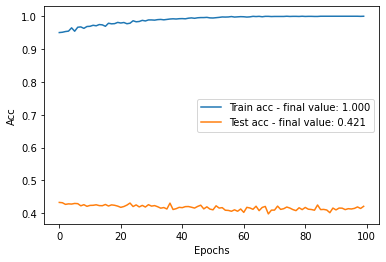

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


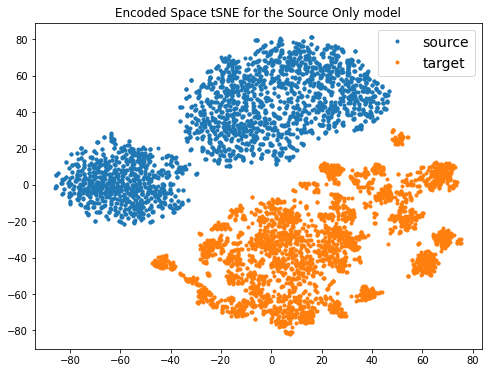

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.029103,0.989775,3.536481,0.417859
std,0.035251,0.013270,1.444844,0.007048
min,0.000362,0.950312,1.322567,0.398125
25%,0.002574,0.983828,2.225079,0.412422
50%,0.012865,0.995938,3.360248,0.417969
75%,0.045947,0.999453,4.723395,0.422891
max,0.137757,1.000000,6.491528,0.433125


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_Resnet_256_RMS_0.5e-5_AU.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 14s 23ms/step - loss: 0.4550 - acc: 0.8537 - disc_loss: 1.3645 - val_loss: 1.6415 - val_acc: 0.4759
Epoch 2/100
400/400 [==============================] - 8s 20ms/step - loss: 0.1178 - acc: 0.9584 - disc_loss: 0.9218 - val_loss: 1.9024 - val_acc: 0.4553
Epoch 3/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0951 - acc: 0.9625 - disc_loss: 0.6801 - val_loss: 1.9724 - val_acc: 0.4197
Epoch 4/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0842 - acc: 0.9681 - disc_loss: 0.5450 - val_loss: 2.8190 - val_acc: 0.4716
Epoch 5/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0900 - acc: 0.9728 - disc_loss: 0.4992 - val_loss: 2.8402 - val_acc: 0.4719
Epoch 6/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0714 - acc: 0.9775 - disc_loss: 0.5325 - val_loss: 3.6051 - val_acc: 0.4475
Epoch 7/100
400/400 [==============================] - 8s 20ms/step - loss:

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 12s 23ms/step - loss: 0.0540 - acc: 0.9903 - disc_loss: 15.2251 - val_loss: 20.5812 - val_acc: 0.5169
Epoch 2/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0526 - acc: 0.9869 - disc_loss: 15.7357 - val_loss: 12.2521 - val_acc: 0.5284
Epoch 3/100
400/400 [==============================] - 8s 21ms/step - loss: 0.1733 - acc: 0.9712 - disc_loss: 14.2087 - val_loss: 35.1457 - val_acc: 0.4978
Epoch 4/100
400/400 [==============================] - 8s 21ms/step - loss: 0.3001 - acc: 0.9394 - disc_loss: 13.7505 - val_loss: 34.4128 - val_acc: 0.4994
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.1655 - acc: 0.9638 - disc_loss: 4.8962 - val_loss: 26.5056 - val_acc: 0.4928
Epoch 6/100
400/400 [==============================] - 8s 21ms/step - loss: 0.1061 - acc: 0.9747 - disc_loss: 5.3300 - val_loss: 23.9778 - val_acc: 0.4903
Epoch 7/100
400/400 [==============================] - 8s 21ms/st

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 23ms/step - loss: 0.4402 - acc: 0.8575 - disc_loss: 1.3794 - val_loss: 1.7004 - val_acc: 0.4750
Epoch 2/100
400/400 [==============================] - 9s 22ms/step - loss: 0.1249 - acc: 0.9528 - disc_loss: 0.9060 - val_loss: 2.0177 - val_acc: 0.4769
Epoch 3/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0950 - acc: 0.9641 - disc_loss: 0.6451 - val_loss: 2.2109 - val_acc: 0.4750
Epoch 4/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0888 - acc: 0.9669 - disc_loss: 0.4970 - val_loss: 2.3564 - val_acc: 0.4644
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0773 - acc: 0.9737 - disc_loss: 0.4192 - val_loss: 2.6007 - val_acc: 0.4669
Epoch 6/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0789 - acc: 0.9706 - disc_loss: 0.4122 - val_loss: 2.6628 - val_acc: 0.4669
Epoch 7/100
400/400 [==============================] - 8s 21ms/step - loss:

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 12s 23ms/step - loss: 0.4556 - acc: 0.8556 - disc_loss: 1.3644 - val_loss: 1.3198 - val_acc: 0.4450
Epoch 2/100
400/400 [==============================] - 8s 21ms/step - loss: 0.1242 - acc: 0.9531 - disc_loss: 0.9175 - val_loss: 1.8673 - val_acc: 0.4544
Epoch 3/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0913 - acc: 0.9647 - disc_loss: 0.6385 - val_loss: 2.1358 - val_acc: 0.4616
Epoch 4/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0914 - acc: 0.9641 - disc_loss: 0.5097 - val_loss: 2.2670 - val_acc: 0.4731
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0691 - acc: 0.9762 - disc_loss: 0.4279 - val_loss: 2.4245 - val_acc: 0.4487
Epoch 6/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0752 - acc: 0.9722 - disc_loss: 0.3641 - val_loss: 2.6003 - val_acc: 0.4544
Epoch 7/100
400/400 [==============================] - 8s 21ms/step - loss:

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 23ms/step - loss: 0.4566 - acc: 0.8491 - disc_loss: 1.3739 - val_loss: 1.7563 - val_acc: 0.4834
Epoch 2/100
400/400 [==============================] - 8s 21ms/step - loss: 0.1199 - acc: 0.9534 - disc_loss: 0.8825 - val_loss: 1.9815 - val_acc: 0.4691
Epoch 3/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0998 - acc: 0.9625 - disc_loss: 0.6370 - val_loss: 1.9807 - val_acc: 0.4528
Epoch 4/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0900 - acc: 0.9700 - disc_loss: 0.5195 - val_loss: 2.5041 - val_acc: 0.4719
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0805 - acc: 0.9678 - disc_loss: 0.4186 - val_loss: 2.3279 - val_acc: 0.4553
Epoch 6/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0690 - acc: 0.9756 - disc_loss: 0.3676 - val_loss: 2.7377 - val_acc: 0.4575
Epoch 7/100
400/400 [==============================] - 8s 21ms/step - loss:

### Result

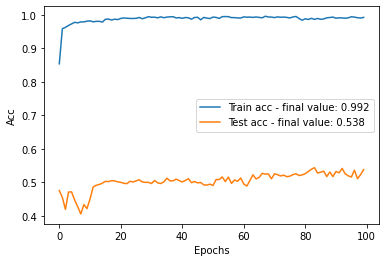

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


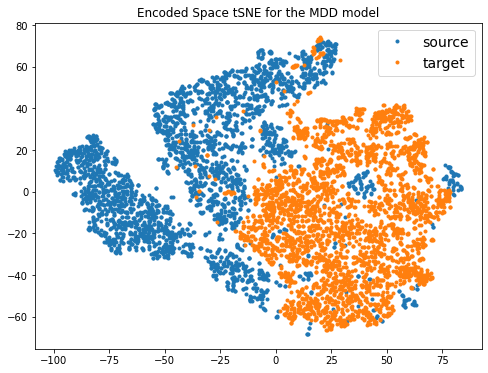

In [ ]:
LC25000_train_data_au_enc = mdd.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.039867,0.987331,1.309611,9.981088,0.504106
std,0.045713,0.014983,0.451226,3.231601,0.026020
min,0.012489,0.853750,0.195154,1.641470,0.406250
25%,0.024447,0.987109,1.125946,8.351416,0.497734
50%,0.028596,0.990781,1.324987,10.472652,0.505625
75%,0.044306,0.992500,1.493973,11.842090,0.520938
max,0.455026,0.995625,3.068560,17.784143,0.544062


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_Resnet_256_RMS_ 0.5e-6_g1_AU.csv")